In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# 指定图像和掩码的文件夹路径
image_dir = r'C:\Users\ZHAO CHAO\ISEP\Data-Analysis-AI-and-Optimization-Project-To-bee-or-not-to-bee-main\train'
mask_dir = r'C:\Users\ZHAO CHAO\ISEP\Data-Analysis-AI-and-Optimization-Project-To-bee-or-not-to-bee-main\train\masks'

# 加载图像和掩码
image_path = r'C:\Users\ZHAO CHAO\ISEP\Data-Analysis-AI-and-Optimization-Project-To-bee-or-not-to-bee-main\train\1.JPG'  # 图像文件路径
mask_path = r'C:\Users\ZHAO CHAO\ISEP\Data-Analysis-AI-and-Optimization-Project-To-bee-or-not-to-bee-main\train\masks\binary_1.tif'    # 掩码文件路径


In [2]:
#data pre-processing

def check_images_and_masks(image_dir, mask_dir):
    images = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')])
    masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
    
    missing_masks = []
    corrupt_files = []
    size_mismatches = []

    for img_filename in images:
        image_path = os.path.join(image_dir, img_filename)
        img_index = os.path.splitext(img_filename)[0]  # 获取图像编号，如 '1' 从 '1.JPG'
        mask_filename = f'binary_{img_index}.tif'
        mask_path = os.path.join(mask_dir, mask_filename)

        # 检查掩码文件是否存在
        if mask_filename not in masks:
            missing_masks.append((img_filename, mask_filename))
            continue

        # 尝试打开图像和掩码文件
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            corrupt_files.append((img_filename, mask_filename))
            continue
        
        # 检查图像和掩码的尺寸是否一致
        if image.shape[:2] != mask.shape:
            size_mismatches.append((img_filename, mask_filename))
    
    return missing_masks, corrupt_files, size_mismatches

missing_masks, corrupt_files, size_mismatches = check_images_and_masks(image_dir, mask_dir)

print("Missing Masks:", missing_masks)
print("Corrupt Files:", corrupt_files)
print("Size Mismatches:", size_mismatches)

Missing Masks: []
Corrupt Files: []
Size Mismatches: []


In [3]:
def remove_image(image_dir, image_filename):
    # 构建图像的完整路径
    image_path = os.path.join(image_dir, image_filename)

    # 检查文件是否存在，然后删除
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Removed {image_path}")
    else:
        print(f"No file found for {image_path}")

# 指定图像文件夹路径和要删除的图像文件名
image_filename = '154.JPG'         # 替换为要删除的图像文件名

remove_image(image_dir, image_filename)

No file found for C:\Users\ZHAO CHAO\ISEP\Data-Analysis-AI-and-Optimization-Project-To-bee-or-not-to-bee-main\train\154.JPG


In [4]:
def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

In [5]:
#Q1：calculate_symmetry_index

def calculate_symmetry_index(masked_image):
    height, width = masked_image.shape[:2]
    mid = width // 2
    left_half = masked_image[:, :mid]
    right_half = cv2.flip(masked_image[:, mid:], 1)
    similarity = np.sum(left_half == right_half) / np.sum(masked_image > 0)
    return similarity

def process_images(image_dir, mask_dir):
    data_symmetry_index = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        base_name = os.path.splitext(image_filename)[0]
        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, base_name + '.tif')
        image, mask = load_image_and_mask(image_path, mask_path)
        masked_image = apply_mask(image, mask)
        symmetry_index = calculate_symmetry_index(masked_image)
        data_symmetry_index.append({"Filename": image_filename, "Symmetry Index": symmetry_index})
    return pd.DataFrame(data_symmetry_index)

# 处理图像并打印结果
results = process_images(image_dir, mask_dir)
print(results.to_string(index=False))

Filename  Symmetry Index
   1.JPG        0.003039
   2.JPG        0.002836
   3.JPG        0.002508
   4.JPG        0.004201
   5.JPG        0.003394
   6.JPG        0.004871
   7.JPG        0.005604
   8.JPG        0.004544
   9.JPG        0.010717
  10.JPG        0.014667
  11.JPG        0.012014
  12.JPG        0.015548
  13.JPG        0.009235
  14.JPG        0.005871
  15.JPG        0.003708
  16.JPG        0.004094
  17.JPG        0.006841
  18.JPG        0.004873
  19.JPG        0.005309
  20.JPG        0.002850
  21.JPG        0.005857
  22.JPG        0.005837
  23.JPG        0.005673
  24.JPG        0.010359
  25.JPG        0.008270
  26.JPG        0.019224
  27.JPG        0.004228
  28.JPG        0.004257
  29.JPG        0.011293
  30.JPG        0.006994
  31.JPG        0.005654
  32.JPG        0.004678
  33.JPG        0.004511
  34.JPG        0.004935
  35.JPG        0.006951
  36.JPG        0.005548
  37.JPG        0.003223
  38.JPG        0.004010
  39.JPG        0.004575


In [6]:
# test with 1.JPG and its mask

def calculate_aspect_ratio(mask):
    # 找到最大轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # 获取面积最大的轮廓
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)  # 计算最小外接矩形
        (width, height) = sorted(rect[1])  # 获取宽度和高度，并确保宽度<=高度
        if height == 0:
            return 0  # 避免除零错误
        ratio = width / height  # 计算比率
        return ratio
    return 0  # 如果没有找到轮廓，返回0

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# 计算比率
ratio = calculate_aspect_ratio(mask)
print("Aspect Ratio:", ratio)


Aspect Ratio: 0.8369826410720307


In [7]:
#Q2:calculate_aspect_ratio

def calculate_aspect_ratio(mask):
    # 找到最大轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        (width, height) = sorted(rect[1])  # 确保宽度小于等于高度
        if height == 0:
            return 0  # 避免除零错误
        return width / height  # 宽度除以高度
    return 0  # 如果没有找到轮廓，返回0

def process_images(image_dir, mask_dir):
    data_aspect_ratio = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        base_name = os.path.splitext(image_filename)[0]
        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
        
        # 加载掩码
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            aspect_ratio = calculate_aspect_ratio(mask)
            data_aspect_ratio.append({"Filename": image_filename, "Aspect Ratio": aspect_ratio})
        else:
            print(f"Mask not found or corrupt: {mask_path}")

    return pd.DataFrame(data_aspect_ratio)

# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)

    Filename  Aspect Ratio
0      1.JPG      0.836983
1      2.JPG      0.685420
2      3.JPG      0.807467
3      4.JPG      0.712455
4      5.JPG      0.750018
..       ...           ...
244  246.JPG      0.985775
245  247.JPG      0.714783
246  248.JPG      0.773522
247  249.JPG      0.944525
248  250.JPG      0.706377

[249 rows x 2 columns]


In [8]:
# test with 1.JPG and its mask

def calculate_pixel_ratio(image, mask):
    total_pixels = image.shape[0] * image.shape[1]  # 图像的总像素数
    bug_pixels = np.count_nonzero(mask)  # 昆虫区域的像素数（掩码中非零的像素数）
    return bug_pixels / total_pixels  # 计算比率


# 加载图像和掩码
image, mask = load_image_and_mask(image_path, mask_path)

# 计算比率
ratio = calculate_pixel_ratio(image, mask)
print("Pixel Ratio (Bug pixels / Total pixels):", ratio)


Pixel Ratio (Bug pixels / Total pixels): 0.007428041666666667


In [9]:
#Q3:calculate_pixel_ratio

def calculate_pixel_ratio(image, mask):
    total_pixels = image.shape[0] * image.shape[1]  # 图像的总像素数
    bug_pixels = np.count_nonzero(mask)  # 昆虫区域的像素数
    return bug_pixels / total_pixels  # 计算比率

def process_images(image_dir, mask_dir):
    data_pixel_ratio = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            
            image, mask = load_image_and_mask(image_path, mask_path)
            if image is not None and mask is not None:
                pixel_ratio = calculate_pixel_ratio(image, mask)
                data_pixel_ratio.append({"Filename": int(base_name), "Pixel Ratio": pixel_ratio})
            else:
                print(f"Error loading image or mask: {image_filename}")

    return pd.DataFrame(data_pixel_ratio)


# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results.to_string(index=False))

 Filename  Pixel Ratio
        1     0.007428
        2     0.008553
        3     0.022093
        4     0.013187
        5     0.009165
        6     0.005917
        7     0.005659
        8     0.007454
        9     0.007199
       10     0.015783
       11     0.013631
       12     0.018040
       13     0.016320
       14     0.010996
       15     0.015961
       16     0.016807
       17     0.014792
       18     0.013739
       19     0.012375
       20     0.019337
       21     0.016044
       22     0.013813
       23     0.016774
       24     0.022505
       25     0.011481
       26     0.016389
       27     0.003765
       28     0.007563
       29     0.014925
       30     0.017855
       31     0.011362
       32     0.009864
       33     0.008156
       34     0.008044
       35     0.005417
       36     0.009457
       37     0.010448
       38     0.011570
       39     0.016585
       40     0.014701
       41     0.009390
       42     0.013254
       43  

In [10]:
# test with 1.JPG and its mask

def calculate_color_stats(image, mask):
    # 应用掩码，只保留昆虫的区域
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # 初始化颜色通道统计数据字典
    color_stats = {
        'Red': {'min': None, 'max': None, 'mean': None},
        'Green': {'min': None, 'max': None, 'mean': None},
        'Blue': {'min': None, 'max': None, 'mean': None}
    }
    
    # 遍历每个颜色通道（0: Blue, 1: Green, 2: Red）
    for i, color in enumerate(['Blue', 'Green', 'Red']):
        channel = masked_image[:, :, i]
        channel_nonzero = channel[channel > 0]  # 只考虑掩码内的非零像素
        
        if channel_nonzero.size > 0:  # 确保存在非零像素
            color_stats[color]['min'] = channel_nonzero.min()
            color_stats[color]['max'] = channel_nonzero.max()
            color_stats[color]['mean'] = channel_nonzero.mean()
        else:
            color_stats[color]['min'] = 0
            color_stats[color]['max'] = 0
            color_stats[color]['mean'] = 0
    
    return color_stats

# 加载图像和掩码
image, mask = load_image_and_mask(image_path, mask_path)

# 计算颜色统计数据
color_stats = calculate_color_stats(image, mask)
for color, stats in color_stats.items():
    print(f"{color} Channel - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']:.2f}")


Red Channel - Min: 5, Max: 208, Mean: 68.09
Green Channel - Min: 3, Max: 199, Mean: 54.88
Blue Channel - Min: 1, Max: 193, Mean: 39.89


In [11]:
#Q4:The min, max and mean values for Red, Green and Blue within the bug mask

def calculate_color_stats(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    color_stats = {
        'Red': {'min': None, 'max': None, 'mean': None},
        'Green': {'min': None, 'max': None, 'mean': None},
        'Blue': {'min': None, 'max': None, 'mean': None}
    }
    for i, color in enumerate(['Blue', 'Green', 'Red']):
        channel = masked_image[:, :, i]
        channel_nonzero = channel[channel > 0]
        if channel_nonzero.size > 0:
            color_stats[color]['min'] = np.min(channel_nonzero)
            color_stats[color]['max'] = np.max(channel_nonzero)
            color_stats[color]['mean'] = np.mean(channel_nonzero)
        else:
            color_stats[color]['min'] = 0
            color_stats[color]['max'] = 0
            color_stats[color]['mean'] = 0
    return color_stats

def process_images(image_dir, mask_dir):
    data_color_stats = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            image, mask = load_image_and_mask(image_path, mask_path)
            if image is not None and mask is not None:
                color_stats = calculate_color_stats(image, mask)
                stats = {
                    "Filename": base_name,
                    "Red Min": color_stats['Red']['min'],
                    "Red Max": color_stats['Red']['max'],
                    "Red Mean": color_stats['Red']['mean'],
                    "Green Min": color_stats['Green']['min'],
                    "Green Max": color_stats['Green']['max'],
                    "Green Mean": color_stats['Green']['mean'],
                    "Blue Min": color_stats['Blue']['min'],
                    "Blue Max": color_stats['Blue']['max'],
                    "Blue Mean": color_stats['Blue']['mean'],
                }
                data_color_stats.append(stats)
            else:
                print(f"Error loading image or mask: {image_filename}")
    return pd.DataFrame(data_color_stats)

# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)


    Filename  Red Min  Red Max    Red Mean  Green Min  Green Max  Green Mean  \
0          1        5      208   68.085745          3        199   54.882747   
1          2        2      248   63.786498          2        251   52.079650   
2          3        3      255  107.176333          2        255   87.794875   
3          4        5      219   87.588243          3        213   71.031852   
4          5        6      255  123.177003          1        250  100.898422   
..       ...      ...      ...         ...        ...        ...         ...   
244      246        7      214   98.700785          7        208   75.144301   
245      247        7      255   89.277366          2        255   65.287788   
246      248        5      252   79.893340          4        239   60.235620   
247      249        6      255  140.451749          3        255  111.768241   
248      250        3      255  127.061504          1        255  101.626731   

     Blue Min  Blue Max   Blue Mean  
0

In [12]:
def calculate_color_statistics(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    color_stats = {
        'Red': {'median': None, 'std_dev': None},
        'Green': {'median': None, 'std_dev': None},
        'Blue': {'median': None, 'std_dev': None}
    }
    for i, color in enumerate(['Blue', 'Green', 'Red']):
        channel = masked_image[:, :, i]
        channel_nonzero = channel[mask > 0]  # 只考虑掩码内的非零像素
        
        if channel_nonzero.size > 0:  # 确保存在非零像素
            color_stats[color]['median'] = np.median(channel_nonzero)
            color_stats[color]['std_dev'] = np.std(channel_nonzero)
        else:
            color_stats[color]['median'] = 0
            color_stats[color]['std_dev'] = 0
    
    return color_stats

# 加载图像和掩码
image, mask = load_image_and_mask(image_path, mask_path)

# 计算颜色统计数据
color_stats = calculate_color_statistics(image, mask)
for color, stats in color_stats.items():
    print(f"{color} Channel - Median: {stats['median']}, Standard Deviation: {stats['std_dev']:.2f}")

Red Channel - Median: 56.0, Standard Deviation: 47.96
Green Channel - Median: 37.0, Standard Deviation: 45.31
Blue Channel - Median: 24.0, Standard Deviation: 36.25


In [13]:
# Q5 : The median and standard deviation for the Red, Green and Blue within the bug mask

def calculate_color_statistics(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    color_stats = {
        'Red': {'median': None, 'std_dev': None},
        'Green': {'median': None, 'std_dev': None},
        'Blue': {'median': None, 'std_dev': None}
    }
    for i, color in enumerate(['Blue', 'Green', 'Red']):
        channel = masked_image[:, :, i]
        channel_nonzero = channel[mask > 0]  # 只考虑掩码内的非零像素
        
        if channel_nonzero.size > 0:
            color_stats[color]['median'] = np.median(channel_nonzero)
            color_stats[color]['std_dev'] = np.std(channel_nonzero)
        else:
            color_stats[color]['median'] = 0
            color_stats[color]['std_dev'] = 0
    
    return color_stats

def process_images(image_dir, mask_dir):
    data_color_statistics = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            image, mask = load_image_and_mask(image_path, mask_path)
            if image is not None and mask is not None:
                color_stats = calculate_color_statistics(image, mask)
                stats = {
                    "Filename": base_name,
                    "Red Median": color_stats['Red']['median'],
                    "Red Std Dev": color_stats['Red']['std_dev'],
                    "Green Median": color_stats['Green']['median'],
                    "Green Std Dev": color_stats['Green']['std_dev'],
                    "Blue Median": color_stats['Blue']['median'],
                    "Blue Std Dev": color_stats['Blue']['std_dev'],
                }
                data_color_statistics.append(stats)
            else:
                print(f"Error loading image or mask: {image_filename}")
    return pd.DataFrame(data_color_statistics)

# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)

    Filename  Red Median  Red Std Dev  Green Median  Green Std Dev  \
0          1        56.0    47.955399          37.0      45.311197   
1          2        55.0    42.153508          34.0      42.866124   
2          3       114.0    58.771359          86.0      60.057604   
3          4        88.0    46.322587          61.0      46.085760   
4          5       134.0    62.355944          91.0      63.029355   
..       ...         ...          ...           ...            ...   
244      246        98.0    46.799467          70.0      43.466326   
245      247        82.0    52.397726          52.0      46.710060   
246      248        60.0    54.355530          37.0      52.163960   
247      249       141.0    57.828557         119.0      52.958137   
248      250       125.0    62.591785          96.0      60.361236   

     Blue Median  Blue Std Dev  
0           24.0     36.250747  
1           19.0     34.617117  
2           52.0     54.823596  
3           36.0     37.445

In [14]:
#Q6: Feature 1 -  Color Entropy  颜色熵

def calculate_color_entropy(image, mask):
    # 应用掩码
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # 计算颜色直方图
    color = ('b','g','r')
    entropy_values = {}
    for i, col in enumerate(color):
        hist = cv2.calcHist([masked_image], [i], mask, [256], [0,256])
        # 归一化直方图
        hist = hist / hist.sum()
        # 计算熵
        entropy = -np.sum(hist * np.log2(hist + 1e-9))  # 加上一个小常数避免对0取对数
        entropy_values[col] = entropy
    
    return entropy_values

# 加载图像和掩码
image, mask = load_image_and_mask(image_path, mask_path)

# 计算颜色熵
color_entropy = calculate_color_entropy(image, mask)
print("Color Entropy:", color_entropy)

Color Entropy: {'b': 6.47609, 'g': 6.9447875, 'r': 7.2400455}


In [15]:
def calculate_color_entropy(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    color = ('b','g','r')
    entropy_values = {}
    for i, col in enumerate(color):
        hist = cv2.calcHist([masked_image], [i], mask, [256], [0,256])
        hist = hist / hist.sum()  # 归一化直方图
        entropy = -np.sum(hist * np.log2(hist + 1e-9))  # 计算熵，加上小常数避免对0取对数
        entropy_values[col] = entropy
    return entropy_values

def process_images(image_dir, mask_dir):
    data_color_entropy = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            image, mask = load_image_and_mask(image_path, mask_path)
            if image is not None and mask is not None:
                color_entropy = calculate_color_entropy(image, mask)
                stats = {
                    "Filename": base_name,
                    "Blue Entropy": color_entropy['b'],
                    "Green Entropy": color_entropy['g'],
                    "Red Entropy": color_entropy['r']
                }
                data_color_entropy.append(stats)
            else:
                print(f"Error loading image or mask: {image_filename}")
    return pd.DataFrame(data_color_entropy)


# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)


    Filename  Blue Entropy  Green Entropy  Red Entropy
0          1      6.476090       6.944788     7.240046
1          2      6.336802       6.779617     7.061750
2          3      7.297956       7.555668     7.691217
3          4      6.782822       7.072619     7.123428
4          5      7.383201       7.531218     7.651067
..       ...           ...            ...          ...
244      246      7.035477       7.281117     7.425443
245      247      6.941242       7.186476     7.485330
246      248      6.899798       6.997389     7.388831
247      249      7.663275       7.622864     7.761568
248      250      7.616251       7.791521     7.836780

[249 rows x 4 columns]


In [16]:
def calculate_area_perimeter_ratio(mask):
    # 找到掩码的轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # 假定最大的轮廓为昆虫的轮廓
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter == 0:
            return 0  # 防止除以零的情况
        return area / perimeter
    return 0

# 加载图像和掩码
_, mask = load_image_and_mask(image_path, mask_path)

# 计算面积与周长比
area_perimeter_ratio = calculate_area_perimeter_ratio(mask)
print("Area-Perimeter Ratio:", area_perimeter_ratio)


Area-Perimeter Ratio: 24.048238382527586


In [17]:
#Q6: Feature 2 -  area_perimeter_ratio  面积周长比

def calculate_area_perimeter_ratio(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter == 0:
            return 0  # 防止除以零的情况
        return area / perimeter
    return 0

def process_images(image_dir, mask_dir):
    data_area_perimeter_ratio = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            _, mask = load_image_and_mask(image_path, mask_path)
            if mask is not None:
                area_perimeter_ratio = calculate_area_perimeter_ratio(mask)
                data_area_perimeter_ratio.append({
                    "Filename": base_name,
                    "Area-Perimeter Ratio": area_perimeter_ratio
                })
            else:
                print(f"Error loading mask: {mask_path}")
    return pd.DataFrame(data_area_perimeter_ratio)


# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)


    Filename  Area-Perimeter Ratio
0          1             24.048238
1          2             25.266996
2          3             44.954051
3          4             31.289472
4          5             28.571679
..       ...                   ...
244      246             54.610503
245      247             89.726498
246      248             47.731600
247      249             84.196255
248      250            109.751116

[249 rows x 2 columns]


In [18]:
def calculate_hu_moments(mask):
    # 找到掩码的轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # 假定最大的轮廓为昆虫的轮廓
        largest_contour = max(contours, key=cv2.contourArea)
        # 计算矩
        moments = cv2.moments(largest_contour)
        # 计算并返回 Hu 矩
        huMoments = cv2.HuMoments(moments)
        # 为了便于比较，取对数
        huMoments = -np.sign(huMoments) * np.log10(np.abs(huMoments))
        return huMoments.flatten()
    return np.zeros(7)  # 如果没有找到有效轮廓，返回全零数组

# 加载图像和掩码
_, mask = load_image_and_mask(image_path, mask_path)

# 计算 Hu 矩
hu_moments = calculate_hu_moments(mask)
print("Hu Moments:", hu_moments)


Hu Moments: [ 0.68897832  3.54592755  3.36761986  4.92741173  9.12330763 -6.87499409
  9.4247124 ]


In [19]:
#Q6: Feature 3 -  hu_moments  hu矩

def calculate_hu_moments(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        huMoments = cv2.HuMoments(moments)
        huMoments = -np.sign(huMoments) * np.log10(np.abs(huMoments) + 1e-10)  # 加小数防止对0取对数
        return huMoments.flatten()
    return np.zeros(7)  # 没有有效轮廓返回全零数组

def process_images(image_dir, mask_dir):
    data_hu_moments = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        if image_filename.endswith('.JPG'):
            base_name = os.path.splitext(image_filename)[0]
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
            _, mask = load_image_and_mask(image_path, mask_path)
            if mask is not None:
                hu_moments = calculate_hu_moments(mask)
                hu_data = {f"Hu Moment {i+1}": moment for i, moment in enumerate(hu_moments)}
                hu_data['Filename'] = base_name
                data_hu_moments.append(hu_data)
            else:
                print(f"Error loading mask: {mask_path}")
    return pd.DataFrame(data_hu_moments)

# 处理图像并输出结果
results = process_images(image_dir, mask_dir)
print(results)


     Hu Moment 1  Hu Moment 2  Hu Moment 3  Hu Moment 4  Hu Moment 5  \
0       0.688978     3.545927     3.367620     4.927408     9.069142   
1       0.630257     2.604580     2.410480     3.640105    -7.068447   
2       0.683230     4.422660     2.536201     4.141483     7.479600   
3       0.666602     2.196348     3.777917     4.505278    -9.093971   
4       0.598313     2.332239     2.264126     3.114501     5.888996   
..           ...          ...          ...          ...          ...   
244     0.670595     2.065372     2.813086     3.625299     6.881107   
245     0.634090     2.071612     3.068474     4.085996    -7.982272   
246     0.618411     2.378088     2.701606     3.883782     7.237954   
247     0.634604     3.448382     1.995445     3.822998     6.871715   
248     0.658498     2.336665     2.366633     3.284525     6.123709   

     Hu Moment 6  Hu Moment 7 Filename  
0      -6.874669     9.322314        1  
1       4.943744     6.701986        2  
2       6.36

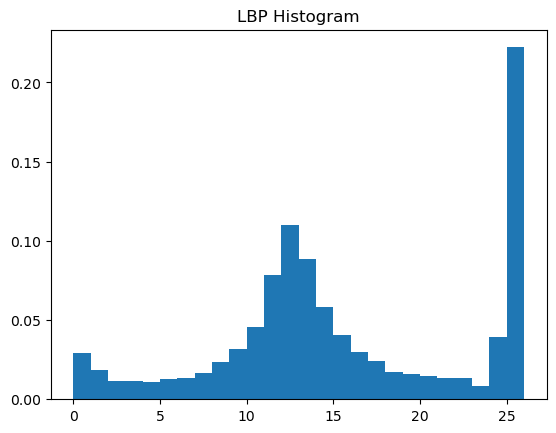

In [20]:
#Q6: Feature 4  （not use）-  局部二值模式（Local Binary Pattern, LBP）  

def load_grey_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)  # 加载原始彩色图像
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 将彩色图像转换为灰度图像
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image_gray, mask

def calculate_lbp_features(image):
    radius = 3  # LBP算法中圆的半径
    n_points = 8 * radius  # 圆周上的点的数量
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp

def plot_lbp_histogram(lbp, mask):
    masked_lbp = lbp[mask > 0]
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(masked_lbp, density=True, bins=n_bins, range=(0, n_bins))
    plt.hist(masked_lbp, bins=n_bins, range=(0, n_bins), density=True)
    plt.title("LBP Histogram")
    plt.show()
    return hist

# 加载图像和掩码
image, mask = load_grey_image_and_mask(image_path, mask_path)

# 应用掩码
masked_image = apply_mask(image, mask)

# 计算LBP特征
lbp = calculate_lbp_features(masked_image)

# 计算并绘制LBP直方图
lbp_histogram = plot_lbp_histogram(lbp, mask)

In [21]:
def load_mask(mask_path):
    # 加载掩码图像，并确保它是灰度格式
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return mask

def calculate_contour_perimeter(mask):
    # 寻找所有轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 选择最大的轮廓
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        # 计算周长，True 表示轮廓是闭合的
        perimeter = cv2.arcLength(largest_contour, True)
        return perimeter
    return 0

# 加载掩码
mask = load_mask(mask_path)

# 计算轮廓周长
perimeter = calculate_contour_perimeter(mask)
print("Contour Perimeter:", perimeter)


Contour Perimeter: 7396.986721873283


In [22]:
#Q6: Feature 5  -  contour_perimeter  轮廓周长

def calculate_contour_perimeter(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        return perimeter
    return 0

def process_masks(mask_dir):
    data_contour_perimeter = []
    mask_filenames = sorted(os.listdir(mask_dir), key=lambda x: int(''.join(filter(str.isdigit, os.path.splitext(x)[0]))))
    for mask_filename in mask_filenames:
        if mask_filename.endswith('.tif'):
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = load_mask(mask_path)
            if mask is not None:
                perimeter = calculate_contour_perimeter(mask)
                data_contour_perimeter.append({
                    "Filename": mask_filename,
                    "Contour Perimeter": perimeter
                })
            else:
                print(f"Error loading mask: {mask_filename}")
    return pd.DataFrame(data_contour_perimeter)

# 处理掩码并输出结果
results = process_masks(mask_dir)
print(results)


           Filename  Contour Perimeter
0      binary_1.tif        7396.986722
1      binary_2.tif        8095.916864
2      binary_3.tif       11725.595140
3      binary_4.tif       10101.065264
4      binary_5.tif        7627.623033
..              ...                ...
244  binary_246.tif        2725.235831
245  binary_247.tif        5337.442239
246  binary_248.tif        3504.921249
247  binary_249.tif        3391.576013
248  binary_250.tif        5089.570099

[249 rows x 2 columns]


In [23]:
def process_all_data(image_dir, mask_dir):
    all_data = []
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG')], key=lambda x: int(x.split('.')[0]))
    for image_filename in image_filenames:
        base_name = os.path.splitext(image_filename)[0]
        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, f"binary_{base_name}.tif")
        image, mask = load_image_and_mask(image_path, mask_path)

        if image is not None and mask is not None:
            color_entropy = calculate_color_entropy(image, mask)
            area_perimeter_ratio = calculate_area_perimeter_ratio(mask)
            hu_moments = calculate_hu_moments(mask)
            contour_perimeter = calculate_contour_perimeter(mask)

            row = {
                "Filename": base_name,
                "Blue Entropy": color_entropy['b'],
                "Green Entropy": color_entropy['g'],
                "Red Entropy": color_entropy['r'],
                "Area-Perimeter Ratio": area_perimeter_ratio,
                "Contour Perimeter": contour_perimeter
            }
            row.update({f"Hu Moment {i+1}": moment for i, moment in enumerate(hu_moments.flatten())})
            all_data.append(row)
        else:
            print(f"Error loading image or mask: {image_filename}")

    df = pd.DataFrame(all_data)
    df.to_csv("combined_features.csv", index=False)  # Save as CSV
    df.to_excel("combined_features.xlsx", index=False)  # Save as Excel
    return df

results =  process_all_data(image_dir, mask_dir)
print(results)

    Filename  Blue Entropy  Green Entropy  Red Entropy  Area-Perimeter Ratio  \
0          1      6.476090       6.944788     7.240046             24.048238   
1          2      6.336802       6.779617     7.061750             25.266996   
2          3      7.297956       7.555668     7.691217             44.954051   
3          4      6.782822       7.072619     7.123428             31.289472   
4          5      7.383201       7.531218     7.651067             28.571679   
..       ...           ...            ...          ...                   ...   
244      246      7.035477       7.281117     7.425443             54.610503   
245      247      6.941242       7.186476     7.485330             89.726498   
246      248      6.899798       6.997389     7.388831             47.731600   
247      249      7.663275       7.622864     7.761568             84.196255   
248      250      7.616251       7.791521     7.836780            109.751116   

     Contour Perimeter  Hu Moment 1  Hu